# Generalized Linear Least Squares

The _linear_ in linear least squares refers to how the parameters appear in the fitting function, $Y$.  So something of the form:

$$Y(x; \{a_j\}) = \sum_{j=1}^M a_j Y_j(x)$$

is still linear in the $\{a_j\}$, even if the _basis functions_ $\{Y_j\}$ are nonlinear.  For example:

$$Y(x; \{a_j\}) = a_1 + a_2 x + a_3 x^2$$

is linear in the fit parameters $\{ a_j\}$.

We can apply the same technique we just did for fitting to a line for this general case.

Our $\chi^2$ is:

$$\chi^2(\{a_j\}) = \sum_{i=1}^N \frac{(Y(x_i; \{a_j\}) - y_i)^2}{\sigma_i^2} =
\sum_{i=1}^N \frac{1}{\sigma_i^2} \left [\left (\sum_{j=1}^M a_j Y_j(x_i)\right ) - y_i \right ]^2$$

We can differentiate it with respect to one of the parameters, $a_k$:

\begin{align*}
\frac{\partial \chi^2}{\partial a_k} 
    &= \frac{\partial}{\partial a_k} 
          \sum_{i=1}^N \frac{1}{\sigma_i^2} \left [\left (\sum_{j=1}^M a_j Y_j(x_i)\right ) - y_i \right ]^2 \\
    &= \sum_{i=1}^N \frac{1}{\sigma_i^2} 
          \frac{\partial}{\partial a_k} \left [\left (\sum_{j=1}^M a_j Y_j(x_i)\right ) - y_i \right ]^2 \\
    &= 2 \sum_{i=1}^N \frac{1}{\sigma_i^2} \left [\left (\sum_{j=1}^M a_j Y_j(x_i)\right ) - y_i \right ] Y_k(x_i) = 0
\end{align*}

We can now rewrite this as:

$$\sum_{i=1}^N \sum_{j=1}^M a_j \frac{Y_j(x_i) Y_k(x_i)}{\sigma_i^2} = \sum_{i=1}^N \frac{y_i Y_k(x_i)}{\sigma_i^2}$$

Defining the _design matrix_ as

$$A_{ij} = \frac{Y_j(x_i)}{\sigma_i}$$

and the source as:

$$b_i = \frac{y_i}{\sigma_i}$$

our system is:

$$\sum_{i=1}^N \sum_{j=1}^M A_{ik} A_{ij} a_j = \sum_{i=1}^N A_{ik} b_i$$

which, by looking at which indices contract, gives us the linear system:

$${\bf A}^\intercal {\bf A} {\bf a} = {\bf A}^\intercal {\bf b}$$

where ${\bf A}^\intercal {\bf A}$ is an $M\times M$ matrix.

## Parabolic Fit

Let's consider fitting to a function:

$$Y(x; \{a_j\}) = \sum_{j=1}^M a_j x^{j-1}$$

for $M = 3$, this is:

$$Y(x) = a_1 + a_2 x + a_3 x^2$$

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def basis(M, x):
    """ the basis function for the fit, x**n"""
    
    j = np.arange(M)
    return x**j

In [8]:
def general_regression(x, y, yerr, M):
    """ here, M is the number of fitting parameters.  We will fit to
        a function that is linear in the a's, using the basis functions
        x**j """

    N = len(x)

    # construct the design matrix -- A_{ij} = Y_j(x_i)/sigma_i -- this is
    # N x M.  Each row corresponds to a single data point, x_i, y_i
    A = np.zeros((N, M), dtype=np.float64)

    for i in range(N):
        A[i,:] = basis(M, x[i])/sigma[i]

    # construct the MxM matrix for the linear system, A^T A:
    ATA = np.transpose(A) @ A

    print("condition number of A^T A:", np.linalg.cond(ATA))

    # construct the RHS
    b = np.transpose(A) @ (y/sigma)

    # solve the system
    a = np.linalg.solve(ATA, b)

    # return the chisq
    chisq = 0
    for i in range(N):
        chisq += (np.sum(a*basis(M, x[i])) - y[i])**2/sigma[i]**2

    chisq /= N-M

    return a, chisq

In [9]:
def y_experiment2(a1, a2, a3, sigma, x):
    """ return the experimental data in a quadratic + random fashion,
        with a1, a2, a3 the coefficients of the quadratic and sigma is
        the error.  This will be poorly matched to a linear fit for
        a3 != 0 """

    N = len(x)

    # randn gives samples from the "standard normal" distribution
    r = np.random.randn(N)

    y = a1 + a2*x + a3*x*x + sigma*r

    return y

In [11]:
N = 40
x = np.linspace(0, 100.0, N)

yerr = 5.0 * np.ones(N)

y = y_experiment2(2.0, 1.50, -0.02, yerr, x)

<ErrorbarContainer object of 3 artists>

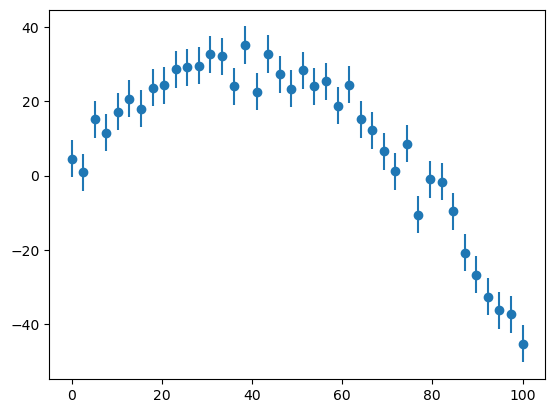

In [12]:
fig, ax = plt.subplots()

ax.errorbar(x, y, yerr=yerr, fmt="o")

In [14]:
# do the regression with M = 3 (1, x, x^2)
M = 3
a, chisq = general_regression(x, y, sigma, M)

condition number of A^T A: 169717921.7365837


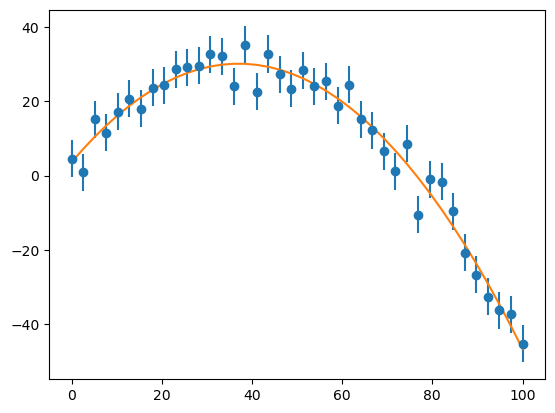

In [15]:
ax.plot(x, a[0] + a[1]*x + a[2]*x*x)
fig